In [ ]:
#Revised code using DEE 2.14 column order

In [28]:
import openpyxl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime

# Load the workbook and sheet
file_path = "DE.xlsx"
wb = openpyxl.load_workbook(file_path)
sheet = wb["DEE"]

# Define categories and keyword triggers
categories = {
    "Missing Info": ["missing", "lack", "no data", "not provided"],
    "Incorrect Info": ["incorrect", "wrong", "error", "misleading", "mistake"],
    "Eligibility Issues": ["eligibility", "ineligible", "qualified", "requirements not met"]
}

# Function to categorize the text from column L (or fallback to G)
def categorize_text(primary_text, fallback_text):
    text = primary_text if primary_text else fallback_text  # Use L if available, else G
    if not text:
        return None
    text = text.lower()
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword in text:
                return category
    return None  # If no category matches

# Initialize a dictionary to hold agent errors by category
agent_errors = defaultdict(lambda: {"Missing Info": 0, "Incorrect Info": 0, "Eligibility Issues": 0})

# Process each row in the sheet
for row in sheet.iter_rows(min_row=2, max_row=sheet.max_row, min_col=1, max_col=12):
    agent_name = row[5].value  # Column F (Agent Name)
    error_text = row[6].value  # Column G (Initial Error Description)
    notes_text = row[11].value  # Column L (Notes / Final Error & Correction)
    
    if agent_name:
        category = categorize_text(notes_text, error_text)  # Prefer L, fallback to G
        if category:
            agent_errors[agent_name][category] += 1

# Prepare data for agent error analysis
agent_error_data = []
for agent, errors in agent_errors.items():
    total_errors = sum(errors.values())
    if total_errors > 0:  # Only include agents who have errors
        agent_error_data.append([agent, errors["Missing Info"], errors["Incorrect Info"], errors["Eligibility Issues"], total_errors])

# Convert to a DataFrame for easier manipulation
df_agent_errors = pd.DataFrame(agent_error_data, columns=["Agent", "Missing Info", "Incorrect Info", "Eligibility Issues", "Total Errors"])

# Sort agent_error_data by Total Errors in descending order
sorted_agent_error_data = sorted(agent_error_data, key=lambda x: x[4], reverse=True)

# Create a unique sheet name with the current date
today = datetime.today().strftime("%Y-%m-%d")
new_sheet_name = f"Errors_{today}"

# Ensure the new sheet name is unique
while new_sheet_name in wb.sheetnames:
    today = (datetime.today() + pd.DateOffset(days=1)).strftime("%Y-%m-%d")
    new_sheet_name = f"Errors_{today}"

# Output Agent Error Analysis to a New Sheet in the Workbook (DE)
wb.create_sheet(new_sheet_name)
error_analysis_sheet = wb[new_sheet_name]
error_analysis_sheet.append(["Agent", "Missing Info", "Incorrect Info", "Eligibility Issues", "Total Errors"])

# Append sorted rows to the new sheet
for row in sorted_agent_error_data:
    error_analysis_sheet.append(row)

# Save the workbook with the new sheet
wb.save(file_path)

# Print completion message
print(f"Error analysis is complete. The new sheet '{new_sheet_name}' has been added to the workbook and sorted by total errors.")


Error analysis is complete. The new sheet 'Errors_2025-02-18' has been added to the workbook and sorted by total errors.


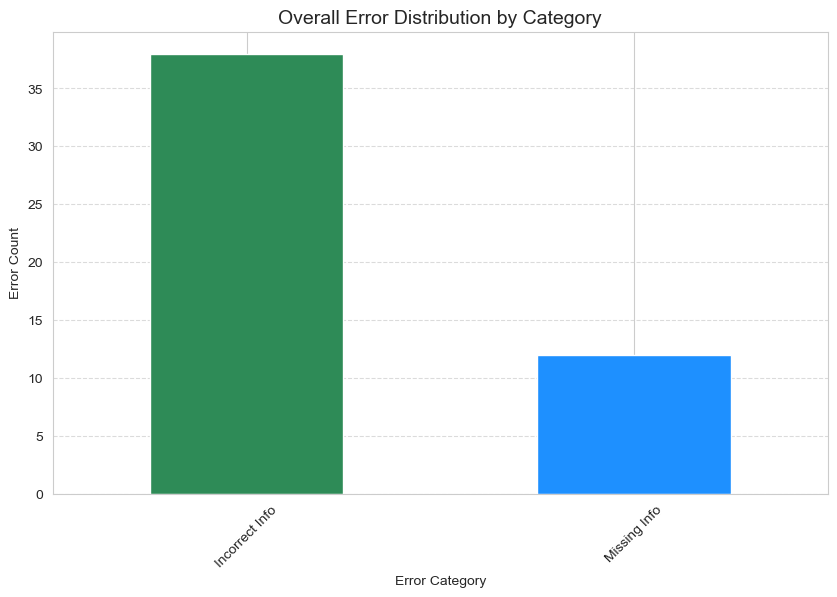

<Figure size 1200x800 with 0 Axes>

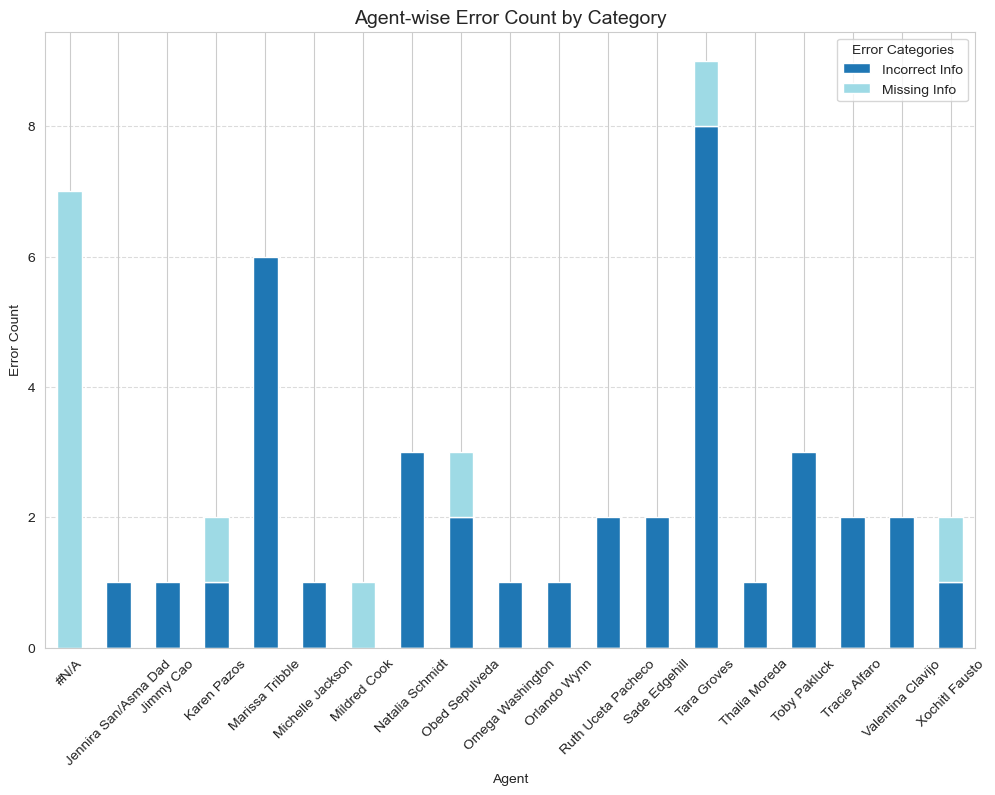

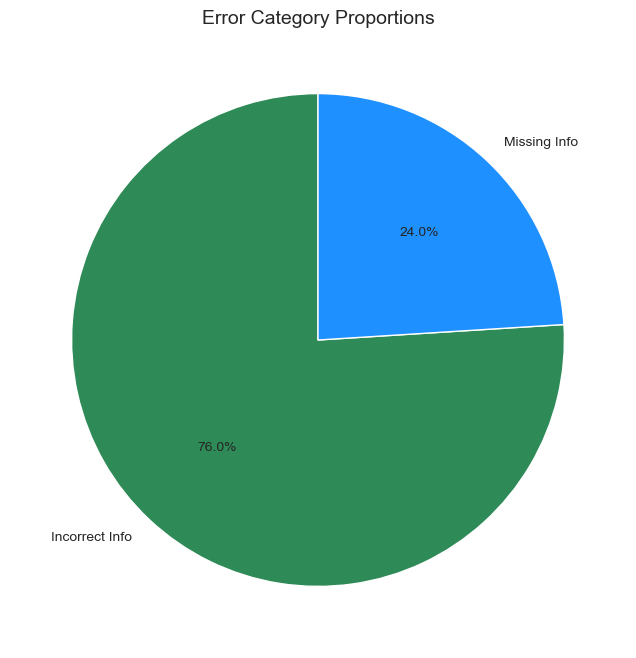

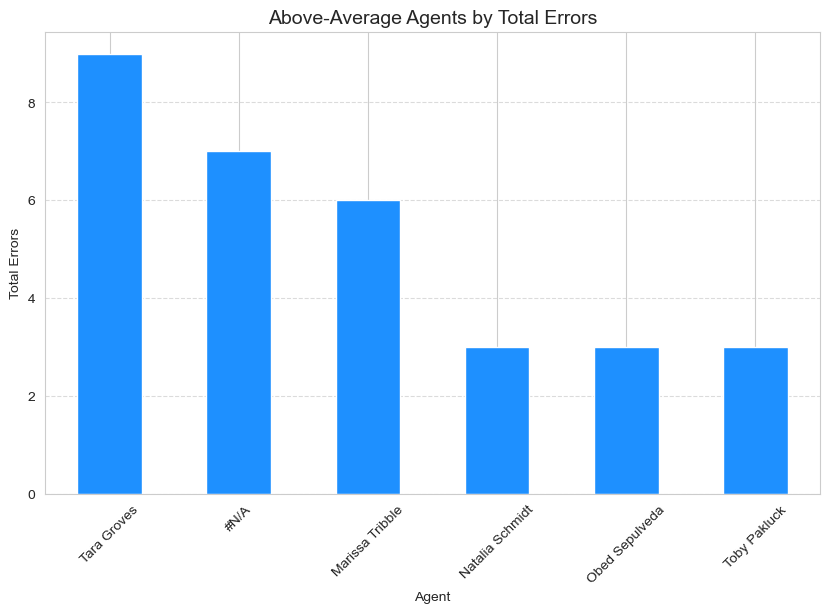

Error analysis and graph generation completed successfully.


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Construct DataFrame from agent_errors dictionary
error_records = []

for agent, error_counts in agent_errors.items():
    for category, count in error_counts.items():
        for _ in range(count):  # Repeat for the number of occurrences
            error_records.append({"Agent": agent, "Category": category})

# Convert to DataFrame
df_errors = pd.DataFrame(error_records)

# Ensure 'df_errors' is not empty
if df_errors.empty:
    print("No errors found. Skipping graph generation.")
else:
    # --- Graph 1: Overall Error Distribution by Category ---
    plt.figure(figsize=(10, 6))
    df_errors["Category"].value_counts().plot(kind="bar", color=["#2E8B57", "#1E90FF", "#FF6347"])
    plt.title("Overall Error Distribution by Category", fontsize=14)
    plt.xlabel("Error Category")
    plt.ylabel("Error Count")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # --- Graph 2: Agent-wise Error Count by Category ---
    plt.figure(figsize=(12, 8))
    agent_error_counts = df_errors.groupby(["Agent", "Category"]).size().unstack().fillna(0)
    agent_error_counts.plot(kind="bar", stacked=True, figsize=(12, 8), colormap="tab20")
    plt.title("Agent-wise Error Count by Category", fontsize=14)
    plt.xlabel("Agent")
    plt.ylabel("Error Count")
    plt.xticks(rotation=45)
    plt.legend(title="Error Categories")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # --- Graph 4: Error Category Proportions ---
    plt.figure(figsize=(8, 8))
    category_proportions = df_errors["Category"].value_counts()
    category_proportions.plot(kind="pie", autopct='%1.1f%%', colors=["#2E8B57", "#1E90FF", "#FF6347"], startangle=90)
    plt.title("Error Category Proportions", fontsize=14)
    plt.ylabel("")  # Hide the y-label
    plt.show()

    # --- Graph 5: Above-Average Agents by Total Errors ---
    agent_error_totals = df_errors.groupby("Agent")["Category"].count()
    average_errors = agent_error_totals.mean()  # Get the average number of errors
    above_average_agents = agent_error_totals[agent_error_totals > average_errors]
    
    plt.figure(figsize=(10, 6))
    above_average_agents.sort_values(ascending=False).plot(kind="bar", color="#1E90FF")
    plt.title("Above-Average Agents by Total Errors", fontsize=14)
    plt.xlabel("Agent")
    plt.ylabel("Total Errors")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

print("Error analysis and graph generation completed successfully.")
